In [1]:
import numpy as np
import xarray as xr
import glob
import cftime

## Go get extra workers

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=36,
                     processes=36, memory="380GB",
                     project='P93300041',
                     walltime='2:00:00')
cluster.scale(36)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=32,
                     processes=32, memory="108GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(32)
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.12.205.30:44873 Dashboard: http://10.12.205.30:8787/status,Cluster Workers: 36 Cores: 36 Memory: 380.16 GB


## Define file paths and preprocess function

In [6]:
thedir = '/glade/scratch/charlie/archive/fates_clm50_global_4x5_historicaltransient_2e3f469f_2905a9ba/lnd/hist/'
paths = sorted(glob.glob(thedir+'*.h0.*'))

In [7]:
data_vars =['SECONDARY_FOREST_FRACTION',
            'PATCH_AREA_BY_AGE',
            'PFTcanopycrownarea',
            'SECONDARY_AREA_PATCH_AGE_DIST',
            'SECONDARY_AREA_AGE_ANTHRO_DIST',
            'NPLANT_SCLS',
            'ED_biomass',
            'area',
            'WOOD_PRODUCT',
            'GPP',
            'NPP']
def preprocess(ds):
    '''specify a smaller set of data_vars'''
    return ds[data_vars]

## Read in the data

In [40]:
%%time 
data_in=xr.open_mfdataset(paths,combine='by_coords',decode_times=False,
                     preprocess=preprocess,parallel=True)
time_vector = cftime.num2date(data_in['time'].values-16,units=data_in['time'].attrs['units'],
                calendar=data_in['time'].attrs['calendar'])
data_in['time']=xr.DataArray(time_vector,dims='time',attrs=data_in['time'].attrs)

CPU times: user 26.6 s, sys: 1.55 s, total: 28.2 s
Wall time: 1min 20s


In [41]:
ntim = len(data_in.variables['time'])

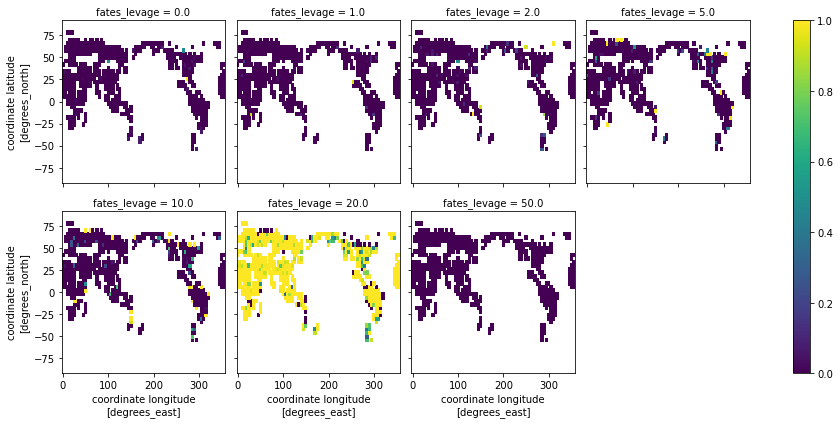

In [43]:
ix = np.logical_and(data_in['time.year']==1900,data_in['time.month']==1)
(data_in.SECONDARY_AREA_AGE_ANTHRO_DIST.sel(time=ix)/data_in.SECONDARY_FOREST_FRACTION.isel(time=ix)).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

## If you want to add some more variables later

In [56]:
data_vars =['TWS']
def preprocess(ds):
    '''specify a smaller set of data_vars'''
    return ds[data_vars]

In [57]:
%%time 
ds2=xr.open_mfdataset(paths,combine='by_coords',decode_cf=False,
                      preprocess=preprocess,parallel=True)
time_vector = cftime.num2date(ds2['time'].values-16,units=ds2['time'].attrs['units'],
                calendar=ds2['time'].attrs['calendar'])
ds2['time']=xr.DataArray(time_vector,attrs=ds2['time'].attrs)
for v in data_vars:
    ds[v]=ds2[v]

CPU times: user 16.3 s, sys: 544 ms, total: 16.8 s
Wall time: 31.9 s
